# HW 7
This assignment covers the overall concepts of Neural Networks and Convolutional Neural Networks.  


## Install Tensorflow 

If ```import tensorflow as tf```  gives Module not found error then it means tensorflow is not installed.

conda: ```conda create -n tf tensorflow  
conda activate tf```

pip: ```pip install tensorflow```

## Tutorials

* [Tensorflow Quickstart](https://www.tensorflow.org/tutorials/quickstart/beginner)
* [MNIST Basic Image Classification w Keras](https://www.tensorflow.org/tutorials/keras/classification)

## Instructions

Keep the following in mind for all notebooks you develop:
* Structure your notebook. 
* Use headings with meaningful levels in Markdown cells, and explain the questions each piece of code is to answer or the reason it is there.
* Make sure your notebook can always be rerun from top to bottom.
* Please start working on this assignment as soon as possible. If you are a beginner in Python this might take a long time. One of the objectives of this assignment is to help you learn python and scikit-learn package. 
* See [README.md](../README.md) for homework submission instructions


# Data Modeling w Tensorflow 

**DO NOT ERASE MARKDOWN CELLS AND INSTRUCTIONS IN YOUR HW submission**

  * **Q** - QUESTION
  * **A** - Where to input your answer

## Data Preparation

We have provided a leaf dataset which contains over 1000 leaf disease images with their ground truth labels in the csv file. You will find the dataset under the data folder. Download the dataset and complete the homework as per below instructions.

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## Tensorflow Dataset

We are using [Tensorflow](https://www.tensorflow.org/tutorials/quickstart/beginner) to train an image classifier model. Tensorflow has it's own apis for creating a data pipeline which makes it easier to feed the data into a Tensorflow model. 
* To use any suitable api to create the data needs to be loaded into a Tensorflow data object. 
* See this API for help: [Directory Dataset](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
* Tensorflow [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

**Q1** Create Data pipeline using the tensorflow api from the image list and labels

1. Create tensorflow train dataset (75% of the whole data)
2. Create tensorflow validation dataset (25% of the whole data)
3. Preprocess the dataset (Apply Horizontal and vertical flips)
4. Resize all images to 128X128
5. Keep the train batch size 32 and validation batch size 16

**A1** Replace ??? with code in the code cell below

In [117]:
from sklearn.model_selection import train_test_split

# Update the directory path based on the relative structure
base_dir = '../data/leaf_dataset/'

# Print the directory structure to debug path issues
print("Base Directory Exists:", os.path.exists(base_dir))
print("Contents of base directory:", os.listdir(base_dir))

# Function to load image paths and labels
def load_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    # List all class directories
    class_folders = ['angular_leaf_spot', 'bean_rust', 'healthy']
    for class_folder in class_folders:
        folder_path = os.path.join(data_dir, class_folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.lower().endswith('.jpg'):
                    img_path = os.path.join(folder_path, img_file)
                    image_paths.append(img_path)
                    labels.append(class_folder)  # Label is the folder name
    return image_paths, labels

# Load the image paths and labels
image_paths, labels = load_image_paths_and_labels(base_dir)
print("Number of images loaded:", len(image_paths))
print("Number of labels loaded:", len(labels))

# Check if dataset is empty
if len(image_paths) == 0:
    raise ValueError("No images found in the directory.")

# Split the data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.25, stratify=labels, random_state=42
)
print("Train paths length:", len(train_paths))
print("Validation paths length:", len(val_paths))

# Convert labels to numeric
label_map = {label: idx for idx, label in enumerate(set(labels))}
train_labels = [label_map[label] for label in train_labels]
val_labels = [label_map[label] for label in val_labels]

# Create TensorFlow datasets
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_data(image_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y))
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create train and validation datasets
tf_train_data = load_data(train_paths, train_labels, batch_size=32)
tf_val_data = load_data(val_paths, val_labels, batch_size=16)

# noticed there was a .csv file that held placeholders for all .jpgs I could have used to iterate through pandas
#tf_train_data = 
#tf_val_data = 

Base Directory Exists: True
Contents of base directory: ['angular_leaf_spot', 'bean_rust', 'healthy', 'train.csv']
Number of images loaded: 1034
Number of labels loaded: 1034
Train paths length: 775
Validation paths length: 259


## Image Visualization

Before going on to form the data pipeline, lets have a look at some of the images in the dataset and visualise them with their labels. 

**Q2**

1. Plot 16 images with their class name from the first batch of the train data (Use 4X4 plot graph)
2. See if images are from different class. If not, modify the train and validation data so that we have different classes in every batch.

**A2** Add cells as per your need below.

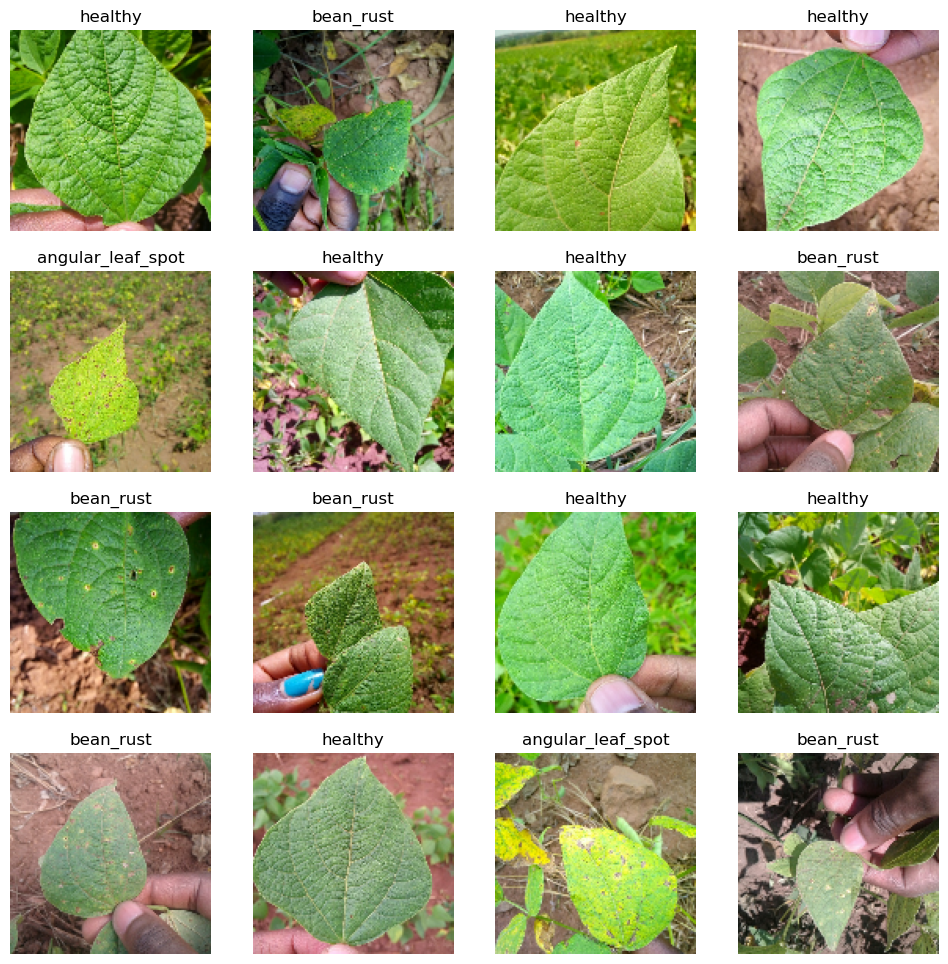

In [118]:
import matplotlib.pyplot as plt

# Function to plot images with their labels
def plot_images(images, labels, label_map, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(label_map[labels[i]])
        plt.axis('off')
    plt.show()

# Get the first batch of train data
for image_batch, label_batch in tf_train_data.take(1):
    # Convert tensors to numpy arrays for visualization
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

# Create label map
label_map = {idx: label for label, idx in label_map.items()}

# Plot 16 images with their class names
plot_images(image_batch, label_batch, label_map, num_images=16)

### Model Definition 

We use Tensorflow to define the model that is Modified LeNet inspired [Keras example](https://www.kaggle.com/niranjanjagannath/lenet-5-architecture-for-mnist-using-tensorflow). 
1. All average pooling layers have been replaced with max pooling layers
2. The input shape is 128X128. The first convolutional layer uses "same" padding to ensure the data is in the same shape as it is in the paper by the time it hits the first pooling layer.

**Q3** Create CNN Model on the training set, and evaluate
1. The model will be of 3 ConV net and followed by MaxPooling after each of them  
* Layer 1 is a convolutional layer (ConV net): Kernel is 3X3 and number of kernel is 6 and ``relu`` as activation function
  * Maxpool after 1st ConV net: 2X2
  * Add 30% Dropout Layer
* Layer 2 is a convolutional layer (ConV net): Kernel is 5X5 and number of kernel is 10 and ``relu`` as activation function
  * Maxpool after 2nd ConV net: 2X2
  * Add 30% Dropout Layer
* Layer 3 is a convolutional layer (ConV net): Kernel is 5X5 and number of kernel is 16 and ``relu`` as activation function
  * Maxpool after 2nd ConV net: 2X2
  * Add 30% Dropout Layer
  * Flatten this  output  
4. Layer 4 is a dense layer with 1024 output units using ``relu`` as activation function
5. Layer 5 is a dense layer with 512 output units using ``relu`` as activation function
6. Layer 6 is a dense layer with 128 output units using ``relu`` as activation function
7. Layer 7 (last layer) is a Dense Layer that is using ``softmax`` as an activation function 

**A3** Replace ??? with code in the code cell below

In [119]:
num_classes = len(label_map)

model = tf.keras.Sequential([
    # Input layer specifying the shape of the input
    tf.keras.layers.Input(shape=(128, 128, 3)),
    
    # Layer 1: Convolutional layer with 3x3 kernels, 6 filters, and ReLU activation
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu'),
    # MaxPooling layer with 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer with 30% dropout
    tf.keras.layers.Dropout(0.3),
    
    # Layer 2: Convolutional layer with 5x5 kernels, 10 filters, and ReLU activation
    tf.keras.layers.Conv2D(10, (5, 5), activation='relu'),
    # MaxPooling layer with 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer with 30% dropout
    tf.keras.layers.Dropout(0.3),
    
    # Layer 3: Convolutional layer with 5x5 kernels, 16 filters, and ReLU activation
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
    # MaxPooling layer with 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer with 30% dropout
    tf.keras.layers.Dropout(0.3),
    
    # Flatten the output
    tf.keras.layers.Flatten(),
    
    # Layer 4: Dense layer with 1024 units and ReLU activation
    tf.keras.layers.Dense(1024, activation='relu'),
    
    # Layer 5: Dense layer with 512 units and ReLU activation
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Layer 6: Dense layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Layer 7: Dense layer with softmax activation for classification
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [120]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 63, 63, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 59, 59, 10)     │         1,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 29, 29, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 29, 29, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 25, 25, 16)     │         4,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,956,865 (11.28 MB)

 Trainable params: 2,956,865 (11.28 MB)

 Non-trainable params: 0 (0.00 B)

## Optimizer and Loss Function

**Q4** Lets set an optimizer for the model training.  Use Tensorflow [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) as the optimizer with the learning rate of 0.001 and the  loss function of [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). We will keep accuracy as the evaluation measure.  Print model summary and see the number of trainable weights

**A4** Replace ??? with code in the code cell below

In [121]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = optimiser, 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics = ['accuracy'])

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 63, 63, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 59, 59, 10)     │         1,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 29, 29, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 29, 29, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 25, 25, 16)     │         4,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,956,865 (11.28 MB)

 Trainable params: 2,956,865 (11.28 MB)

 Non-trainable params: 0 (0.00 B)

We have loaded the training data, and compiled the model, now it is time to train it. The validation dataset has been included here so that the model validates its accuracy after each step by making predictions against the validation dataset.  Each epoch takes under a minute to complete so this may take a few minutes to run depending on your machine. 

## Train the CNN and Plot the Accuracy
**Q5** Start the training using fit function
1. Pass train data inside fit function
2. Provide validation data inside fit function
3. Define number of epochs(For faster training set it equal to 15)

**A5** Replace ??? with code in the code cell below


In [122]:
train_log = model.fit(
    tf_train_data, # Training data
    validation_data=tf_val_data, # Validation data
    epochs=15
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3064 - loss: 1.5072 - val_accuracy: 0.3320 - val_loss: 1.0986
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3094 - loss: 1.0982 - val_accuracy: 0.4170 - val_loss: 1.0963
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3340 - loss: 1.0949 - val_accuracy: 0.4517 - val_loss: 1.0866
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4178 - loss: 1.0728 - val_accuracy: 0.3282 - val_loss: 1.1057
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3402 - loss: 1.1329 - val_accuracy: 0.3127 - val_loss: 1.0951
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4383 - loss: 1.0376 - val_accuracy: 0.5598 - val_loss: 0.9400
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5416 - loss: 0.9255 - val_accuracy: 0.5444 - val_loss: 0.9566
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6081 - loss: 0.8742 - val_accuracy: 0.6216 - v

**Q6** Create plot on the training set, and validation set. Use ``history`` attribute from the above train_log for creating accuracy curve.


**A6** Replace ??? with code in the code cell below


Training accuracy: 0.717419
Validation accuracy: 0.664093


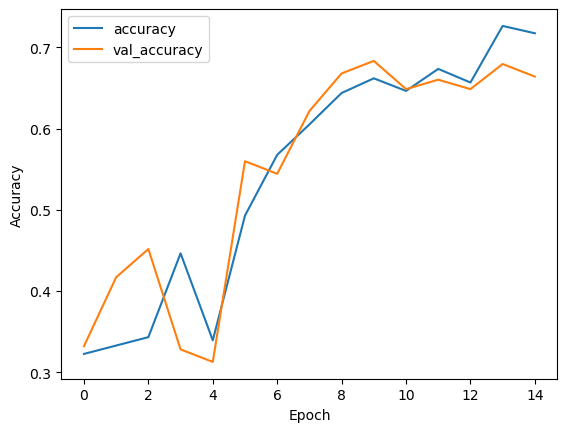

In [123]:
plt.plot(train_log.history['accuracy'], label='accuracy')
plt.plot(train_log.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % train_log.history['accuracy'][-1])
print('Validation accuracy: %f' % train_log.history['val_accuracy'][-1])

## Plot few validation set prediction
Now that we have the trained model, lets use it to classify some images. The model will output a probability for each possible class. Numpys argmax is thus used to find the class with the highest probability and this class is used for the image.

**Q7** Use the trained model to predict the first batch of the validation set
1. Pass first batch validation data inside predict function of trained model
2. Use numpy ``argmax`` to get the index with best classificaion score.
3. Find the corresponding class name from the prediction class id.
3. Plot the predicted class name with the images same as you did for the ```Q. No 2``` (Use 4X4 graph for plotting)

**A7** Add any number of cells you need

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


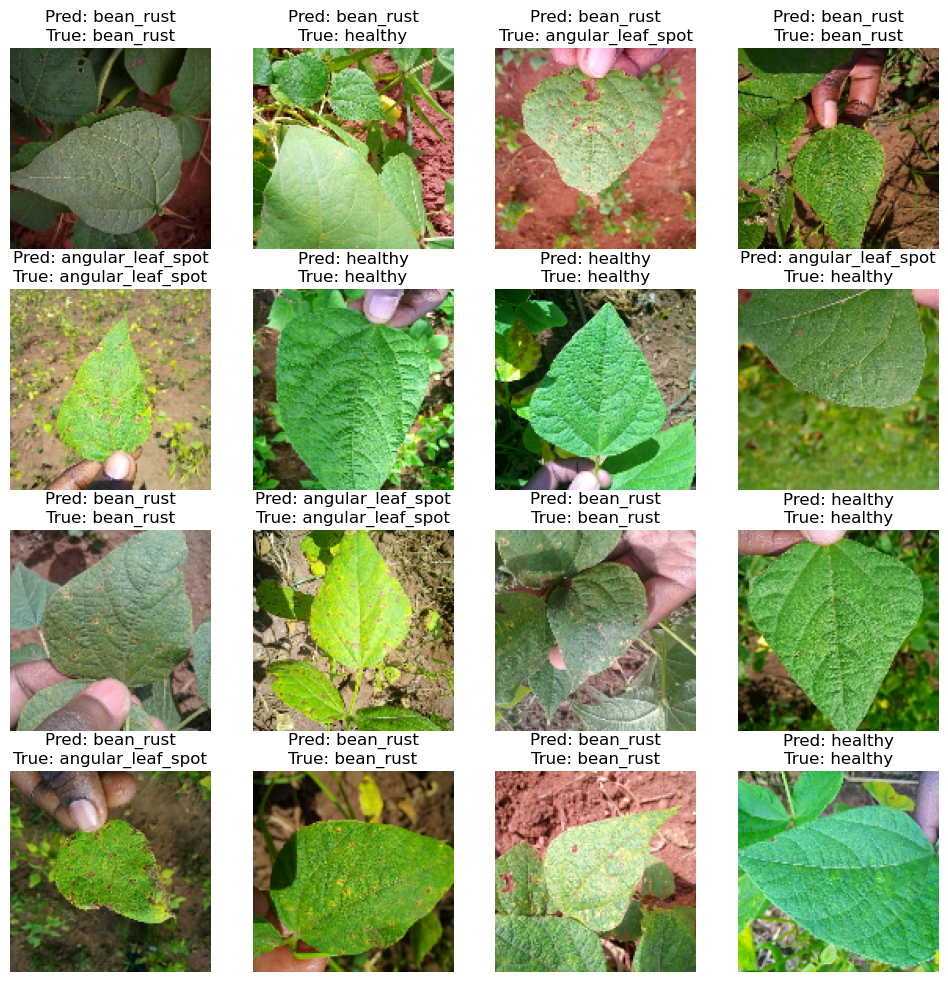

In [124]:
#predictions = model.predict(??)
#predictions = np.argmax(??)
                        
# Predict on the first batch of validation data
for image_batch, label_batch in tf_val_data.take(1):
    # Predict class probabilities for the first batch
    predictions = model.predict(image_batch)
    
    # Get the predicted class IDs
    predicted_class_ids = np.argmax(predictions, axis=-1)
    
    # Convert predicted class IDs to class names
    predicted_class_names = [label_map[id] for id in predicted_class_ids]

    # Convert label_batch to class names for comparison
    true_class_names = [label_map[id] for id in label_batch.numpy()]

    # Function to plot images with their predicted and true labels
    def plot_images(images, predicted_labels, true_labels, num_images=16):
        plt.figure(figsize=(12, 12))
        for i in range(num_images):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i])
            plt.title(f'Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}')
            plt.axis('off')
        plt.show()

    # Plot the images with predicted and true class names
    plot_images(image_batch.numpy(), predicted_class_names, true_class_names, num_images=16)

## Additional Reading
    
* [Neural Network](https://www.bmc.com/blogs/neural-network-introduction/)

* [Convolutional Neural Network](https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529)

* [Tensorflow Framework](https://www.datacamp.com/community/tutorials/cnn-tensorflow-python)